In [1]:
# coding=utf8

import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
plt.style.use(plt.style.available[0])

In [2]:
# 加载数据
df = pd.read_csv('data/DQC00-1d.txt',
                 sep=',',
                 nrows=5000,
                 index_col=['datetime'],  # 设置行索引
                 parse_dates=['datetime'],  # 解析时间 20100104130500.0
                 date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d%H%M%S.%f'),  # 时间解析的格式，进行毫秒级数据解析
                 usecols=['datetime', 'open', 'high', 'low', 'close', 'volume'],  # 设置需要用到的列
                 encoding='utf-8',
                 float_precision='round_trip',  # 所有数据会当做string读取, 使用时再进行相应的转换为float
                 )
# pd.reset_option('display.float_format')  # 重置
pd.set_option('precision', 2)  # 显示小数点后的位数
pd.set_option('display.max_rows', 300)  # 控制显示的最大行数
pd.set_option('display.min_rows', 20)  # 确定显示的部分有多少行
# pd.set_option('display.float_format',  '{:,.2f}'.format) # 数字格式化显示 用逗号格式化大值数字 设置数字精度
# 指定列名设置计算精确度，未指定的保持原样
df.round({'open':0, 'high':0, 'low':0, 'close':0 })
# 统一保持1位小数
df.round(0)
# 设置np输出精度
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=2, suppress=True)

In [3]:
print(df.dtypes)
df.head()

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


,open,high,low,close,volume
datetime,,,,,
2004-09-22,1143.23,1147.88,1106.05,1106.98,77908.0
2004-09-23,1097.68,1099.54,1089.32,1093.04,37196.0
2004-09-24,1082.81,1101.40,1082.81,1095.83,29367.0
2004-09-27,1092.11,1100.47,1075.38,1076.31,17336.0
2004-09-28,1077.24,1088.39,1077.24,1082.81,26681.0


In [4]:
# 2.1 缺失值处理

# 检查数据中是否有缺失值，以下两种方式均可
#Flase:对应特征的特征值中无缺失值
#True：有缺失值
print(df.isnull().any())
print(np.isnan(df).any())
#返回每一列缺失值统计个数
print(df.isnull().sum())

open      False
high      False
low       False
close     False
volume    False
dtype: bool
open      False
high      False
low       False
close     False
volume    False
dtype: bool
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [5]:
#缺失值处理，以下两种方式均可
#删除包含缺失值的行
df.dropna(inplace=True)
#缺失值填充
# df.fillna('100')

#返回每一列缺失值统计个数
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [6]:
print(df[:3])
# 2.2 确定特征值 目标值
# 特征值取开盘价和收盘价的差值
X = (df[['open','high','low']]).values
print(type(X),X.shape,X.ndim)

print(X[:3,])

               open     high      low    close   volume
datetime                                               
2004-09-22  1143.23  1147.88  1106.05  1106.98  77908.0
2004-09-23  1097.68  1099.54  1089.32  1093.04  37196.0
2004-09-24  1082.81  1101.40  1082.81  1095.83  29367.0
<class 'numpy.ndarray'> (4173, 3) 2
[[1143.23 1147.88 1106.05]
 [1097.68 1099.54 1089.32]
 [1082.81 1101.4  1082.81]]


In [7]:
# 目标值取开盘价和收盘价的差值
# y = df.iloc[:, -2:-1].values.ravel()
Y = (df['close']).values
print(Y.shape)
print(Y.ndim)
print(Y[:3])


(4173,)
1
[1106.98 1093.04 1095.83]


In [8]:
#将数据划分为训练集和验证集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y.reshape(-1,1),
                                                    random_state=None,
                                                    test_size=0.50,  #测试集50%样本数量
                                                    shuffle=True,  #default=True 切分前是否对数据进行打乱。
                                                    )


In [9]:
print(x_train.shape, y_train.shape,y_train.ndim)
print(x_test.shape, y_test.shape,y_test.ndim)
np.hstack((x_test, y_test))[:3]

(2086, 3) (2086, 1) 2
(2087, 3) (2087, 1) 2


array([[1633.05, 1640.49, 1629.33, 1632.12],
       [1985.53, 1993.05, 1979.68, 1990.54],
       [1194.35, 1201.78, 1191.56, 1198.99]])

In [10]:
## 混淆测试集目标类别的 指定概率50%的错误
err = x_train
for i in range(int(len(err) * 0.0)):
    index = int(np.random.randint(len(err)))
    # index2 = int(np.random.randint(len(err)))
    # err[index,0], err[index,3] = err[index,3], err[index,0]
    err[index] = 0

In [11]:
# 3. 特征工程（标准化）
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

x_train_stand = standardScaler.fit_transform(x_train)
x_test_stand = standardScaler.transform(x_test)

y_train_stand = standardScaler.fit_transform(y_train)
y_test_stand = standardScaler.transform(y_test)

In [12]:
print(x_train.shape)
print(x_train.ndim)
print(y_train.shape)
print(y_train.ndim)
print(x_train[:10])
print(x_train[:10,0])

(2086, 3)
2
(2086, 1)
2
[[1769.09 1780.52 1767.19]
 [1588.44 1588.44 1583.79]
 [2629.69 2641.29 2614.21]
 [2042.11 2042.11 2036.05]
 [2063.78 2066.4  2061.17]
 [2122.88 2124.66 2112.21]
 [2093.76 2098.15 2092.01]
 [2061.34 2070.1  2057.83]
 [1153.45 1159.03 1133.  ]
 [1682.31 1694.39 1670.23]]
[1769.09 1588.44 2629.69 2042.11 2063.78 2122.88 2093.76 2061.34 1153.45
 1682.31]


In [13]:
#画图观察
# fig, ax = plt.subplots()
# ax.scatter(y_test_stand, x_test_stand)
# ax.plot([y_test_stand.min(), y_test_stand.max()], [y_test_stand.min(), y_test_stand.max()], 'k--', lw=2)
# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# plt.show()

In [14]:
# 拟合回归模型
svr_rbf = SVR(kernel='rbf', C=1.00, gamma=1, epsilon=0.05)
svr_lin = SVR(kernel='linear', C=1.00, gamma='auto', epsilon=0.1)
svr_poly = SVR(kernel='poly', C=1.00, gamma='auto',
               degree=3,  #默认=3 多项式核函数的次数(' poly ')。将会被其他内核忽略。
               epsilon=.15,
               coef0=0.1,  #默认=0.0 核函数中的独立项。它只在' poly '和' sigmoid '中有意义
               )

In [15]:
x_train.shape, x_test.shape
# np.vstack((x_train,x_test)).shape

((2086, 3), (2087, 3))

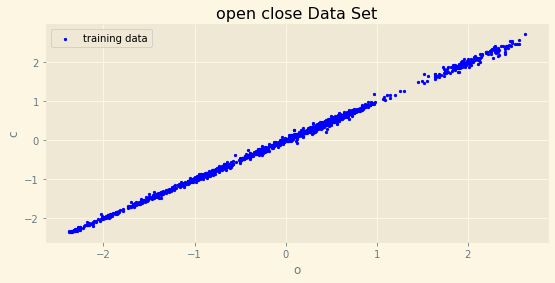

In [16]:
plt.figure(figsize=(9, 4))  # width, height in inches
n_set_plt = plt.scatter(x_train_stand[:,0], y_train_stand, c='b', s=5, label='training data')
plt.xlabel('o')
plt.ylabel('c')
plt.title('open close Data Set')
plt.legend(loc="upper left")
plt.savefig(r'./file/02_svm_svr_linear_.png', dpi=200)
plt.show()


ix=0, svcs=SVR(epsilon=0.05, gamma=1)
估计器的参数: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.05, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
训练集评分: 0.9995789514490698 
测试集评分: 0.9995726719590623 
ix=1, svcs=SVR(gamma='auto', kernel='linear')
估计器的参数: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
训练集评分: 0.9995572092095326 
测试集评分: 0.9995936963585786 
ix=2, svcs=SVR(coef0=0.1, epsilon=0.15, gamma='auto', kernel='poly')
估计器的参数: {'C': 1.0, 'cache_size': 200, 'coef0': 0.1, 'degree': 3, 'epsilon': 0.15, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
训练集评分: 0.9923638082179583 
测试集评分: 0.9925357881956481 


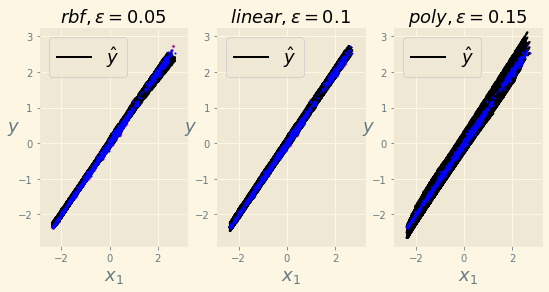

In [17]:
def plot_svm_regression(svm_reg, X, y, axes):
    y_pred = svm_reg.predict(X)
    plt.plot(X[:,0], y_pred, "k-", linewidth=2, label=r"$\hat{y}$")  # 预测的回归线
    plt.plot(X[:,0], y_pred + svm_reg.epsilon, "k--")  # 回归线向上平移epsilon
    plt.plot(X[:,0], y_pred - svm_reg.epsilon, "k--")  # 回归线向下平移epsilon
    plt.scatter(X[svm_reg.support_,0], y[svm_reg.support_], s=10, facecolors='#FFAAAA')
    plt.plot(X[:,0], y, "b.", markersize=2)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)



plt.figure(figsize=(9, 4))
xx = np.vstack((x_train_stand[:,],x_test_stand[:,]))
yy = np.vstack((y_train_stand,y_test_stand))
x_min, x_max = xx.min() - 0.5, xx.max() + 0.5
y_min, y_max = yy.min() - 0.5, yy.max() + 0.5

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["rbf", "linear", "poly"]
for ix, svr in enumerate(svrs):
    fit = svr.fit(x_train_stand, y_train_stand.ravel())
    # 获取预测值
    y_test_pred = fit.predict(x_test_stand)
    # 显示估计器
    print(f'ix=%s, svcs=%s' % (ix, svrs[ix]))
    # 获取这个估计器的参数
    print(f'估计器的参数: %s' % (svr.get_params()))
    # https://blog.csdn.net/gracejpw/article/details/101546293
    # 返回预测的决定系数R^2
    # R^2越接近于1，模型的拟合优度越高。
    print(f'训练集评分: %s ' %(fit.score(x_train_stand, y_train_stand)))
    print(f'测试集评分: %s ' % (svr.score(x_test_stand, y_test_stand)))


    plt.subplot(1,3,ix+1)
    plot_svm_regression(fit, xx, yy, [x_min, x_max, y_min, y_max])
    plt.title(r"${}, \epsilon = {}$".format(fit.kernel, fit.epsilon), fontsize=18)
    plt.ylabel(r"$y$", fontsize=18, rotation=0)

plt.savefig(r'./file/02_svm_svr.png', dpi=200)



svm: (50, 3)
epsilon:0.05 = [[17.54]]
mean平均值: 5.27
std标准差: 7.37
var方差: 54.28
svm平均间隔 507.73
svm间隔std 555.27
#查看切分后的数据与切分前的数据是否一致 [[2773.79 2773.79 1082.81]
 [2593.08 2593.08 1073.52]
 [1979.02 1979.02 1193.42]
 [2246.   2246.   1177.62]
 [1057.72 1057.72 1150.66]]
#查看训练集的支持向量 [[2746.71 2780.56 2714.8  2746.93 2767.13 2728.44]
 [2560.47 2596.05 2550.59 2560.62 2583.5  2563.33]
 [1984.78 1995.34 1936.77 1984.71 1985.67 1946.14]
 [2265.66 2270.57 2244.03 2265.69 2259.58 2255.1 ]
 [1055.86 1057.72 1050.28 1055.44 1052.55 1054.8 ]
 [1232.46 1234.31 1219.44 1232.1  1228.3  1224.88]
 [2221.43 2305.96 2215.53 2221.45 2294.8  2226.43]
 [2041.46 2047.54 1980.74 2041.42 2037.62 1990.36]
 [1915.78 1980.42 1912.13 1915.69 1970.82 1921.37]
 [2780.56 2814.41 2777.66 2780.79 2800.81 2791.65]]
查看预测值与目标值的差值 [[1633.05 1640.49 1629.33    0.32   -7.12    4.04   -0.93   -8.37    2.79
    -1.25]
 [1985.53 1993.05 1979.68    0.39   -7.12    6.24    5.01   -2.51   10.86
     4.62]
 [1194.35 1201.78 1191.56   

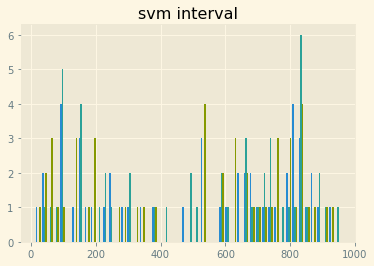

In [18]:
svrs = [svr_rbf, svr_lin, svr_poly]

fit = svrs[0]

print('svm:',fit.support_vectors_.shape)
support_vectors_ = standardScaler.inverse_transform(fit.support_vectors_)
epsilon_1 = standardScaler.inverse_transform(np.array([[fit.epsilon],]))
epsilon_0 = standardScaler.inverse_transform(np.array([[0.00],]))
print('epsilon:%s = %s'%(fit.epsilon , epsilon_1 - epsilon_0))

y_test_pred = fit.predict(x_test_stand)
y_test_pred_ = standardScaler.inverse_transform(y_test_pred.reshape(-1,1))
y_test_ = standardScaler.inverse_transform(y_test_stand.reshape(-1,1))
y_train_ = standardScaler.inverse_transform(y_train_stand.reshape(-1,1))
print('mean平均值:', np.mean(abs((y_test_ - y_test_pred_))).round(2))
print('std标准差:', np.std(((y_test_ - y_test_pred_))).round(2))
print('var方差:', np.var(((y_test_ - y_test_pred_))).round(2))
print('svm平均间隔',np.mean(abs(support_vectors_- epsilon_0)).round(2))
print('svm间隔std',np.std((support_vectors_- epsilon_0)).round(2))

print('#查看切分后的数据与切分前的数据是否一致',(np.hstack(((y_train[fit.support_]), (y_train_[fit.support_]),
                                         (Y[:len(y_train)][fit.support_].reshape(-1,1)) )))[:5])
print('#查看训练集的支持向量',np.hstack((((x_train)[fit.support_]), (support_vectors_) ))[:10])

print('查看预测值与目标值的差值',(np.hstack((x_test, (y_test_pred_ - x_test), (y_test_ - x_test), (y_test - y_test_pred_)))[:5]))


interval = abs(support_vectors_ - epsilon_0)
plt.hist(interval, bins=50)
plt.title('svm interval')
plt.show()

In [19]:
# figure number
fignum = 1
plt.figure(fignum, figsize=(4, 3))

# plt.scatter(np.arange(len(y_test_stand)), y_test_stand, s=5, c='blue')
# plt.scatter(y_test_pred, y_test_pred, s=5, c='r')

plt.show()

<Figure size 288x216 with 0 Axes>

In [20]:
fit = svr_rbf
print('support_支持向量的下标',fit.support_.shape)
print('support_vectors_支持向量',fit.support_vectors_.shape)
print('n_support_每个类别的支持向量数量',fit.n_support_)
print('dual_coef_决策函数中支持向量的系数',fit.dual_coef_.shape)
print('intercept_决策函数中的常量',fit.intercept_)

support_支持向量的下标 (50,)
support_vectors_支持向量 (50, 3)
n_support_每个类别的支持向量数量 [50]
dual_coef_决策函数中支持向量的系数 (1, 50)
intercept_决策函数中的常量 [0.12]
